In [1]:
import torch
import torchvision
from complex_resnet import complex_resnet18, complex_resnet34, complex_resnet50

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from shnetutil.cplx import visual

fftlib = np.fft
from kornia import color

In [2]:
import numpy as np
from PIL import Image
from coshrem.shearlet import construct_shearlet
from numpy.random import randint
from skimage.transform import resize

from coshrem.util.cone import cone_orientation
from coshrem.shearlet import construct_shearlet

from shnetutil import cplx, shxform
from shnetutil.shxform import CoShREMConfig
from shnetutil.utils import torchutils
from shnetutil.cplx import visual

# Default parameters for our Shearlet system
# https://www.math.colostate.edu/~king/software/CoShREM_Parameter_Guide.pdf
#

ksh_spec = CoShREMConfig(
			rows = 32,
			cols = 32,
			scales_per_octave = 2,
			shear_level = 3,
			octaves = 1,
			alpha = .5,	#   Anisotropy level
						#	alpha: coefficient determining level of anisotropy. 
						#	1 -> wavelets, 
						#	0.5 -> shearlets, 
						#	0 -> ridgelets... etc.

			wavelet_eff_support = 7,
			gaussian_eff_support = 14,
)

def get_sh_spec(rows:int, cols:int, alpha:float=0.5):
	""" Configure a sh_spec for our Shearlet system """
	sh_spec = ksh_spec.copy()
	sh_spec['rows'] = rows
	sh_spec['cols'] = cols
	sh_spec['alpha'] = alpha
	return sh_spec

def get_CoShXform(device:str, rows:int, cols:int, alpha:float=0.5):
	""" Start a CoShXform """
	sh_spec = get_sh_spec(rows, cols, alpha)
	coshxform = CoShXform(sh_spec)
	coshxform.start(device)
	return coshxform	

def power_of_two(target):
	""" round to next power-of-2 """
	if target > 1:
		for i in range(1, int(target)):
			if (2 ** i >= target):
				return 2 ** i
	else:
		return 1

class CoShXform(shxform.ShXform):
	def __init__(self,
		sh_spec = ksh_spec, 
		tocplx = False,
		topolar = False,
		phase_first = False
	):
		""" Generating the shearlet system with pyCoShRem """
		super().__init__(sh_spec=sh_spec)	#default complex Shearlet spec - usually provided by client
		nextp2 = power_of_two(self.dim[0])
		assert(nextp2 == self.dim[0])
		self.ourdim = (nextp2, nextp2)
		self.tocplx = tocplx
		self.topolar = topolar
		self.phase_first = phase_first
		#print(f"CoShXform: {sh_spec}")

	def __repr__(self):	
		return f"CoShXform({self.sh_spec})"	

	def __str__(self):
		return f"CoShXform({self.sh_spec})"	

	def start(self, device):
		super().start(device)

		#t = time.time()
		self._shearletSystem = getcomplexshearlets2D(**dict(self.sh_spec))
		#self.shearlets, self.shearletIdxs = self.shearletSystem
		#print(f"Elapsed time: getcomplexshearlets2D() {time.time()-t:3f}ms")

		#for pytorch deal with the imaginary and real part we separate them into two arrays
		shearlets_complex = to_torch_complex(self.shearlets)
		self.shearlets_complex = shearlets_complex
		self.torch_shearlets = torch.tensor(shearlets_complex).unsqueeze(0).to(device).float()
	
def to_torch_complex(shearlets):
	"""for pytorch to deal with the imaginary and real part we separate them into two arrays """
	#print(f"to_torch_complex {shearlets.shape}")
	shearlets_complex = np.concatenate((
		shearlets.real[:,:,:,np.newaxis], 
		shearlets.imag[:,:,:,np.newaxis]), 
		3
	)
	return shearlets_complex

# ## Relevant CoShReM function

# Single shearlet computation
def _single_shearlet(
	rows, cols, 
	wavelet_eff_supp,
	gaussian_eff_supp, scales_per_octave,
	shear_level, alpha, 
	sample_wavelet_off_origin,
	scale, ori, _coneh, _ks, hilbert_matrix
):
	shearlet_f = construct_shearlet(rows, cols, wavelet_eff_supp,
								  gaussian_eff_supp, scales_per_octave,
								  shear_level, alpha,
								  sample_wavelet_off_origin, scale, ori, _coneh, _ks)

	if ori in _coneh:
		shearlet_f = shearlet_f + (hilbert_matrix[:, :, 0] * shearlet_f)
		# shearlet_f = np.fliplr(np.flipud(_hilbert_f(shearlet_f * -1)))
		# if not self.sampleWaveletOffOrigin:
		#     shearlet_f = np.roll(shearlet_f, -1, axis=0)
	else:
		if ori > np.max(_coneh):
			shearlet_f = -1 * (shearlet_f + hilbert_matrix[:, :, 1] * shearlet_f)
			# shearlet_f = _hilbert_f(shearlet_f.T * -1).T
			# shearlet_f = np.roll(shearlet_f, 1, axis=1)
		else:
			shearlet_f = shearlet_f + hilbert_matrix[:, :, 1] * shearlet_f
			# shearlet_f = _hilbert_f(shearlet_f.T).T
	return shearlet_f

def getcomplexshearlets2D(
	rows, 
	cols, 
	scales_per_octave, 
	shear_level, 
	octaves, alpha,
	wavelet_eff_support = 7,
	gaussian_eff_support = None,
):

	# Parameters precomputing
	gaussian_eff_support = gaussian_eff_support if gaussian_eff_support else wavelet_eff_support * 2 
	wavelet_eff_supp = np.min((rows, cols)) / wavelet_eff_support
	gaussian_eff_supp = np.min((rows, cols)) / gaussian_eff_support
	sampleWaveletOffOrigin= True

	hilbert_matrix = np.ones((rows, cols, 2))
	hilbert_matrix[:(rows//2), :, 0] = -1
	hilbert_matrix[:, (cols//2):, 1] = -1
	n_oris = 2 ** shear_level + 2
	scales = np.arange(1, (scales_per_octave * octaves) + 1)
	n_shearlets = len(scales) * n_oris

	normalize=True
	_, _coneh, _ks =  cone_orientation(shear_level)
	shearlets = np.zeros((rows, cols,n_shearlets), dtype=np.complex_)
	shearletidx = []
	# Computing shearlets
	for j, scale in enumerate(scales):
		for ori in range(n_oris):
			shearlet = _single_shearlet(rows, cols, wavelet_eff_supp,
						   gaussian_eff_supp, scales_per_octave,
						   shear_level, alpha, sampleWaveletOffOrigin,
						   scale, ori+1, _coneh, _ks, hilbert_matrix)

			if ori in _coneh:
				shearletidx.append([1,int(scale), _ks[ori]])
			else:
				shearletidx.append([2,int(scale), _ks[ori]])
			shearlets[:, :, n_oris * j + ori] = shearlet
	# Computing RMS (Root mean square)
	RMS = np.linalg.norm(shearlets[0], axis=(0, 1))/np.sqrt(rows*cols)
	dualFrameWeights = np.sum(np.power(np.abs(shearlets), 2), axis=2)
	return shearlets, shearletidx, RMS, dualFrameWeights



In [3]:
def is_peak(coeffs):
    coeffs = np.array(coeffs)
    up = np.roll(coeffs, 1, -2)
    down = np.roll(coeffs, -1, -2)
    right = np.roll(coeffs, 1, -3) < coeffs
    left = np.roll(coeffs, -1, -3) < coeffs

    up_right = np.roll(coeffs, 1, -3) < coeffs
    up_left = np.roll(coeffs, -1, -3) < coeffs
    down_right = np.roll(down, 1, -3) < coeffs
    down_left = np.roll(down, -1, -3) < coeffs

    up = up < coeffs
    down = down < coeffs

    mask = up * down * right * left * up_right * up_left * down_right * down_left
    return mask

def suppress_peaks(coeffs):
    peaks = is_peak(coeffs)
    coeffs[peaks] = 0
    return coeffs

def suppress_non_peak(coeffs):
    peaks = is_peak(coeffs)
    coeffs[~peaks] = 0
    return coeffs
    
def suppress_small(coeffs, percent=10):
    importance = np.abs(coeffs.real)

    qLower = np.percentile(importance, percent) # 10% sparsity
    mask = importance < qLower

    coeffs[mask] = 0

    return coeffs 


def suppress_square(coeffs, i=1):
    x, y = coeffs.shape[0], coeffs.shape[1]

    coeffs[-i:] = 0
    coeffs[:i] = 0
    coeffs[:, :i] = 0
    coeffs[:, -i:] = 0

    return coeffs 

def sheardec2D(X, shearlets):
    #skipping useGPU stuff...
    coeffs = np.zeros(shearlets.shape, dtype=complex)

    # get data in frequency domain
    Xfreq = fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(X)))
    # print('frequency domain')
    # visual.complexImageShow(Xfreq / Xfreq.max())
    # plt.show()

    # compute shearlet coefficients at each scale
    # note that pointwise multiplication in the fourier domain equals
    # convolution in the time-domain
    for j in range(shearlets.shape[-1]):
        coeffs[:,:,j] = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift(Xfreq * np.conj(shearlets[:,:,j]))))

    return coeffs


def shearrec2D(coeffs, shearlets, dualFrameWeights):
    # skipping useGPU stuff...
    X = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)
    Y = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)

    for j in range(shearlets.shape[-1]):
        X = X + fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(coeffs[:,:,j]))) * shearlets[:,:,j]
        Y = Y + fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(coeffs[:,:,j])))
    
    X = suppress_square(X, 96)
    Y = suppress_square(Y, 96)

    print((X == 0).sum() / X.flatten().shape[0], 'sparsity')
    print('shearlet conv domain')
    visual.complexImageShow(Y / Y.max())
    plt.show()

    InversedualFrameWeights = 1 / dualFrameWeights
    InversedualFrameWeights[InversedualFrameWeights==np.inf] = 0.0

    X = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift((X*InversedualFrameWeights))))

    return np.real(X)

<class 'numpy.ndarray'> 0 254


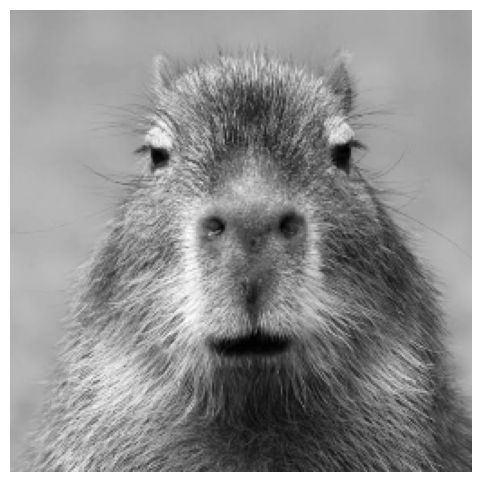

sh_spec: rows=256 cols=256 scales_per_octave=1 shear_level=3 octaves=2 alpha=0.5 wavelet_eff_support=64 gaussian_eff_support=128
torchutils.onceInit device = cuda:0
initSeeds(1)
0.28969737844752597
0.953125 sparsity
shearlet conv domain


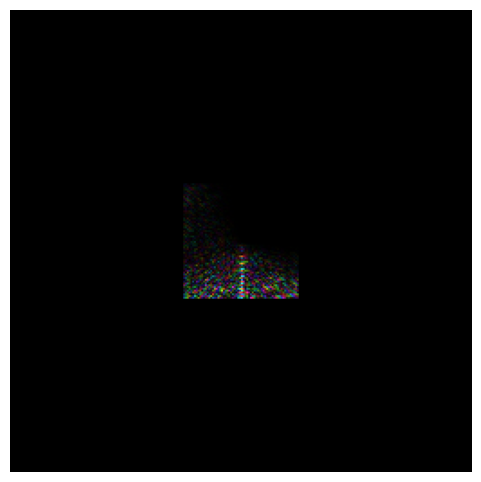

C:\Users\jaycr\AppData\Local\Temp\ipykernel_27088\2533114690.py:86: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights = 1 / dualFrameWeights


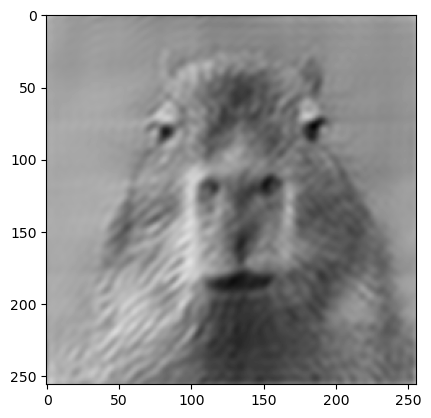

In [4]:
size = 256
img = np.array(Image.open("capybara.png").convert('L'))
print(type(img), img.min(), img.max())
image = resize(img, (size,size))

plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(image, cmap = "gray")
plt.show()

# Relevant parameters for our Shearlet system
rows, cols = image.shape
sh_spec = CoShREMConfig(rows = rows,
                        cols = cols,
                        scales_per_octave = 1,
                        shear_level = 3,
                        octaves = 2,
                        alpha = 0.5,
                        wavelet_eff_support = 64,
                        gaussian_eff_support = 128)

print(f"sh_spec: {sh_spec}")

# Generating the shearlet system with pyCoShRem
device = torchutils.onceInit(kCUDA=True)
coshxform = CoShXform(sh_spec)
coshxform.start(device)

shearlets, shearletIdxs, RMS, dualFrameWeights = coshxform.shearletSystem

print(RMS)

coeffs = sheardec2D(image, shearlets)
recon = shearrec2D(coeffs, shearlets, dualFrameWeights)

#recon = recon.real - recon.real.min()
#recon = recon / recon.max()

# visual.complexImageShow(recon)
plt.imshow(recon.real, cmap='gray', vmin=0, vmax=1)
plt.show()

In [5]:
# GOAL: get the input that is passed to coshnet (coefficients or shearlet space?) with the intended sparsity level.

def sparse_shearenc2D(X, shearlets):
    #skipping useGPU stuff...
    coeffs = np.zeros(shearlets.shape, dtype=complex)

    # get data in frequency domain
    Xfreq = fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(X)))
    # print('frequency domain')
    # visual.complexImageShow(Xfreq / Xfreq.max())
    # plt.show()

    # compute shearlet coefficients at each scale
    # note that pointwise multiplication in the fourier domain equals
    # convolution in the time-domain
    X = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)
    Y = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)
    
    # TODO: vectorize

    X = Xfreq[..., np.newaxis] * np.conj(shearlets) * shearlets
    Y = Xfreq[..., np.newaxis] * np.conj(shearlets)

    X = suppress_square(X, 96)
    Y = suppress_square(Y, 96)

    # TODO: use torch so we can vectorize even this process
    for j in range(shearlets.shape[-1]):
        coeffs[:,:,j] = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift(Y[:,:,j])))

    print((X == 0).sum() / X.flatten().shape[0], 'sparsity')
    print('shearlet conv domain')
    visual.complexImageShow(Y.sum(-1) / Y.sum(-1).max())
    plt.show()

    print('inverse shifted shearlet conv domain')
    visual.complexImageShow(fftlib.fftshift(Y).sum(-1) / fftlib.fftshift(Y).sum(-1).max())
    plt.show()

    print('shifted shearlet conv domain')
    visual.complexImageShow(fftlib.fftshift(Y).sum(-1) / fftlib.fftshift(Y).sum(-1).max())
    plt.show()

    print('coeffs domain')
    visual.complexImageShow(coeffs.sum(-1) / coeffs.sum(-1).max())
    plt.show()

    return coeffs


def sparse_sheardec2D(coeffs, shearlets, dualFrameWeights):
    # skipping useGPU stuff...
    X = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)
    Y = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)

    for j in range(shearlets.shape[-1]):
        X = X + fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(coeffs[:,:,j]))) * shearlets[:,:,j]
        Y = Y + fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(coeffs[:,:,j])))
    
    X = suppress_square(X, 112)
    Y = suppress_square(Y, 112)

    print((X == 0).sum() / X.flatten().shape[0], 'sparsity')
    print('shearlet conv domain')
    visual.complexImageShow(Y / Y.max())
    plt.show()
    

    InversedualFrameWeights = 1 / dualFrameWeights
    InversedualFrameWeights[InversedualFrameWeights==np.inf] = 0.0

    X = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift((X * InversedualFrameWeights))))

    return np.real(X)

0.96875 sparsity
shearlet conv domain


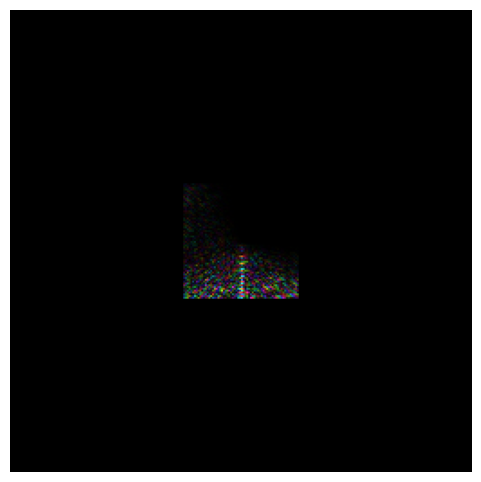

inverse shifted shearlet conv domain


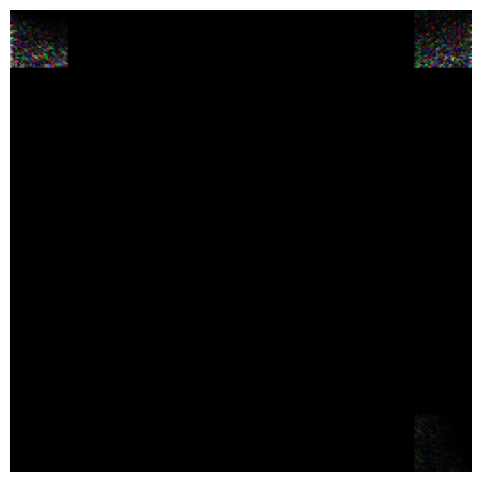

shifted shearlet conv domain


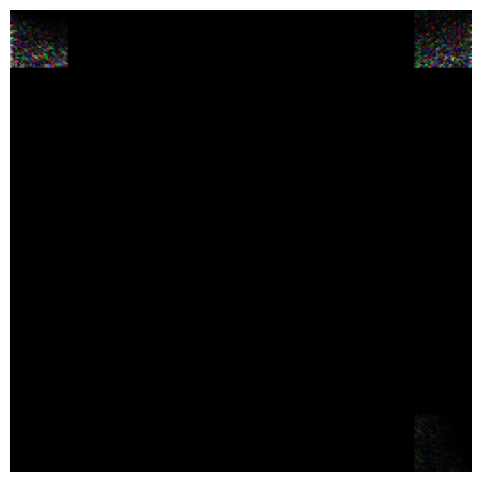

coeffs domain


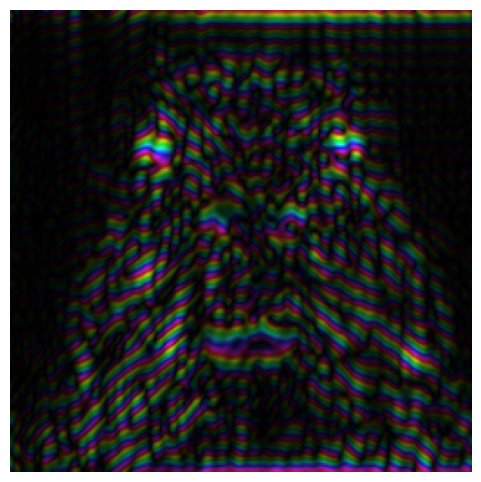

0.98828125 sparsity
shearlet conv domain


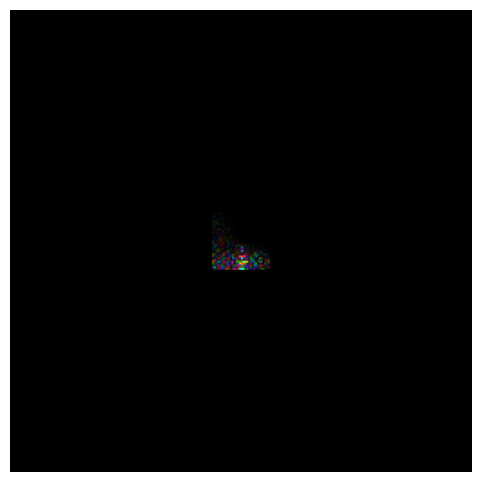

C:\Users\jaycr\AppData\Local\Temp\ipykernel_27088\489785732.py:69: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights = 1 / dualFrameWeights


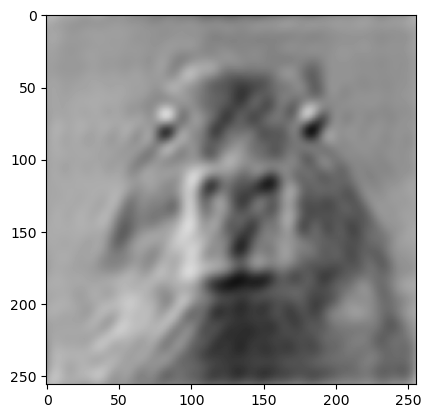

In [6]:
# GOAL: determine the best input format to tokenize to use few constant-sized tokens for any resolution.
coeffs = sparse_shearenc2D(image, shearlets)
recon = sparse_sheardec2D(coeffs, shearlets, dualFrameWeights)

plt.imshow(recon.real, cmap='gray', vmin=0, vmax=1)
plt.show()
# the input is not structurally (or at all?) sparse in the coefficient domain.
# the structure of our sparsity is only present in the frequency domain, so we must use that.


In [7]:
# GOAL: tokenize the input

# there are a couple of ways we can approach tokenizing the frequency domain input:

# 1. take some patch size and just take that much from the center of the band and use each band as a token.
# for patch sizes like 32x32 this requires large weight matrices automatically.
# this approach virtually limits the detail that can be processed by any network as the weight/space complexity is quadratic in the "detail"
# this approach might have many tokens
# this approach requires only a single dimension of positional embedding

# 2. patch the frequency domain into tokens
# this approach limits the resolutions that can be sparsified
# this approach requires two domains of positional embedding

def suppress_square(coeffs, i=1, crop=False):

    if crop:
        coeffs = coeffs[..., i:-i, i:-i]
    else:
        coeffs[..., :, -i:] = 0
        coeffs[..., :, :i] = 0
        coeffs[..., :i, :] = 0
        coeffs[..., -i:, :] = 0

    return coeffs 

def spatial_coefficients(X, shearlets, patch_size=32):
    fftlib = torch.fft
    coeffs = torch.zeros(shearlets.shape, dtype=torch.complex64)
    X = X.to(0)

    # get data in frequency domain
    Xfreq = fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(X, dim=(-2, -1))), dim=(-2, -1))
    # print('frequency domain')
    # visual.complexImageShow(Xfreq / Xfreq.max())
    # plt.show()

    # compute shearlet coefficients at each scale
    # note that pointwise multiplication in the fourier domain equals
    # convolution in the time-domain
    Y = torch.zeros((shearlets.shape[-2], shearlets.shape[-1]), dtype=torch.complex64).to(0)

    Y = Xfreq.unsqueeze(0) * torch.conj(shearlets)

    Y = suppress_square(Y, (Y.shape[-1] - patch_size) // 2)

    # use torch so we can vectorize even this process
    coeffs = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift(Y, dim=(-2, -1))), dim=(-2, -1))

    return coeffs

def batched_spatial_coefficients(X, shearlets, patch_size=32):
    fftlib = torch.fft
    coeffs = torch.zeros(shearlets.shape, dtype=torch.complex64)
    X = X.to(0)

    # get data in frequency domain
    Xfreq = fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(X, dim=(-2, -1))), dim=(-2, -1))
    # print('frequency domain')
    # visual.complexImageShow(Xfreq / Xfreq.max())
    # plt.show()

    # compute shearlet coefficients at each scale
    # note that pointwise multiplication in the fourier domain equals
    # convolution in the time-domain
    Y = torch.zeros((shearlets.shape[-2], shearlets.shape[-1]), dtype=torch.complex64).to(0)

    Y = Xfreq.unsqueeze(1) * torch.conj(shearlets).unsqueeze(0)

    Y = suppress_square(Y, (Y.shape[-1] - patch_size) // 2)

    # use torch so we can vectorize even this process
    coeffs = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift(Y, dim=(-2, -1))), dim=(-2, -1))

    return coeffs

def frequency_coefficients(X, shearlets, patch_size=32):
    fftlib = torch.fft
    coeffs = np.zeros(shearlets.shape, dtype=complex)

    # get data in frequency domain
    Xfreq = fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(X, dim=(-2, -1))), dim=(-2, -1))
    # print('frequency domain')
    # visual.complexImageShow(Xfreq / Xfreq.max())
    # plt.show()

    # compute shearlet coefficients at each scale
    # note that pointwise multiplication in the fourier domain equals
    # convolution in the time-domain
    X = Xfreq[np.newaxis] * np.conj(shearlets) * shearlets

    X = suppress_square(X, (X.shape[-1] - patch_size) // 2)

    return X


def batched_frequency_coefficients(X, shearlets, patch_size=32):
    fftlib = torch.fft
    X = X.to(0)
    # get data in frequency domain
    Xfreq = fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(X, dim=(-2, -1))), dim=(-2, -1))
    # print('frequency domain')
    # visual.complexImageShow(Xfreq / Xfreq.max())
    # plt.show()

    # compute shearlet coefficients at each scale
    # note that pointwise multiplication in the fourier domain equals
    # convolution in the time-domain
    X = Xfreq.unsqueeze(1) * (torch.conj(shearlets).unsqueeze(0) * shearlets.unsqueeze(0))

    X = suppress_square(X, (X.shape[-1] - patch_size) // 2, True)

    return X

# **Want to Know**:
#### - **how do we embed patches of the frequency domains of the shearlet coefficients?** 

## Papers to read regarding fourier domain transformers

### Scattering Vision Transformer: Spectral Mixing Matters
- https://papers.neurips.cc/paper_files/paper/2023/file/a97f8072e51a785434b2da3e9cbf5aae-Paper-Conference.pdf

    It is highly improbable that the level of complexity in this work is merited by its very marginal improvement over prior work.  The presentation is rife with errors and it seems unlikely that this direction will be profitable.  Anyway, it isn't based on fourier or wavelet or shearlet analysis.  It has good references for us though.

- https://papers.neurips.cc/paper_files/paper/2022/file/5a8177df23bdcc15a02a6739f5b9dd4a-Paper-Conference.pdf
- https://arxiv.org/abs/2104.02555
- https://ieeexplore.ieee.org/document/9834158
- https://openaccess.thecvf.com/content/CVPR2022W/CVMI/papers/Buchholz_Fourier_Image_Transformer_CVPRW_2022_paper.pdf
- https://www.ecva.net/papers/eccv_2022/papers_ECCV/papers/136840001.pdf
- http://ecmlpkdd2017.ijs.si/papers/paperID11.pdf

## Fourier Transformers
- https://openaccess.thecvf.com/content/CVPR2022/papers/Tang_An_Image_Patch_Is_a_Wave_Phase-Aware_Vision_MLP_CVPR_2022_paper.pdf
- https://arxiv.org/abs/2105.03824
- https://arxiv.org/abs/2107.00645

## Adaptive Fourier Neural Operators: Efficient Token Mixers for Transformers
- https://arxiv.org/abs/2111.13587


## Wave-ViT: Unifying Wavelet and Transformers for Visual Representation Learning
- https://arxiv.org/abs/2207.04978

    This work proposes a wavelet block to perform "lossless" spatial downsampling to reduce the token count for keys and values during the self-attention computation.  **They wrote a differentiable version of the wavelet transform for this project**.  Unfortunately they are doing this computation [on the patch space](https://github.com/YehLi/ImageNetModel/blob/0b4302e0b10ff12013b03b799dda50393efa69a9/classification/wavevit.py#L410) which appears to make very little sense in the context of the wavelet transform.  One encouraging thing is their smallest model appears to be performing much better than the other models of similar scale, but there does not seem to be a meaningful improvement in the operation count which is unfortunate. 

### Wavelet-Based Image Tokenizer for Vision Transformers
- https://arxiv.org/abs/2405.18616

    This paper utilizes the approximate structure of the sparsity in the wavelet analysis of images to reduce the size of the tokens input to vision transformers.  Because each step of the analysis reduces the resolution exponentially, but increases the size of their tokens linearly, then by introducing structured sparsity into the different scales of the analysis the size of the resulting embedding can be reduced.  This is tantamount in reality to filtering out high-frequency components (though their framework allows for the reverse to occur).  Either way, a heuristic decision is made based on the relative importance of different frequencies in the input which is determined by the rate of occurence of that "frequency" or wavelet response.  If the low frequency elements occur with greater magnitude coefficients more frequently then these elements are preserved.  There is a weakness to this approach:

    1. If the frequency elements that are important for the task at hand appear with high magnitude seldom, then they are intentionally filtered out of the input which could lead to problems in the presence of class imbalance or similar

    seems easy enough to make these into shearlets: 
    - https://en.wikipedia.org/wiki/Daubechies_wavelet
    - https://en.wikipedia.org/wiki/Coiflet

    though coshrem must be popular for a reason...

    Remember: This paper mentions non-uniform gridding in the context of token merging, dropping, or similar as it relates to numerical differential equations.  This could be an important future direction.

### Fourier Neural Operator for Parametric Partial Differential Equations
https://arxiv.org/abs/2010.08895

    This is an interesting paper with broad implications for science, but it is out of the scope of this project.  I think spectral PDE solvers are adjacent to the mathematics needed to understand building a good tokenizer in the frequency domain, but they are not essential to doing so.

In [8]:
single_views = ['DINOv2', 'CLIP', 'EsViT', 'SwAV', 'MAE']

double_views = [[view1, view2] for i, view1 in enumerate(single_views)  for view2 in single_views[i + 1:] if single_views[i + 1:]]
double_views

[['DINOv2', 'CLIP'],
 ['DINOv2', 'EsViT'],
 ['DINOv2', 'SwAV'],
 ['DINOv2', 'MAE'],
 ['CLIP', 'EsViT'],
 ['CLIP', 'SwAV'],
 ['CLIP', 'MAE'],
 ['EsViT', 'SwAV'],
 ['EsViT', 'MAE'],
 ['SwAV', 'MAE']]

In [9]:
'DINOv2'.split('-')

['DINOv2']

In [10]:
from tqdm import tqdm

def train(model, optimizer, loader, accumulate=1):
    model.train()
    loss = torch.nn.CrossEntropyLoss()

    for i, (X, y) in tqdm(enumerate(loader)):
        out = model(X.to(0))
        optimizer.zero_grad()
        l = loss(out, y.to(0)) / accumulate
        l.backward()
        if i % accumulate == (accumulate - 1):
            optimizer.step()
        

def accuracy(output, target, topk=(1,)):
    output = output.to(torch.device('cpu'))
    target = target.to(torch.device('cpu'))
    maxk = max(topk)
    batch_size = target.shape[0]

    _, idx = output.sort(dim=1, descending=True)
    pred = idx.narrow(1, 0, maxk).t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(dim=0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def epoch_accuracy(loader_s, student):
    student.eval()

    out_epoch_s = [accuracy(student(L.to(0)), y)[0].detach().cpu().item() for L, y in loader_s]

    student.train()

    return sum(out_epoch_s) / len(out_epoch_s)

def test(network, test_loader):
    network.eval().to(0)
    test_loss = 0
    correct = 0
    total = 0
    test_losses=[]
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.to(0))
            test_loss += torch.nn.CrossEntropyLoss()(output, target.to(0)).item()
            pred = output.data.max(1, keepdim=True)[1].cpu()
            correct += pred.eq(target.data.view_as(pred)).sum()
            total += target.shape[0]
        test_loss /= total
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total,
        100. * correct / total))

### Global Experiment Parameters 

In [11]:
patch_size = 32
image_size = 128

rows, cols = image_size, image_size

sh_spec = CoShREMConfig(rows = rows,
                        cols = cols,
                        scales_per_octave = 1,
                        shear_level = 3,
                        octaves = 1,
                        alpha = 0.5,
                        wavelet_eff_support = image_size // 2,
                        gaussian_eff_support = image_size)

print(f"sh_spec: {sh_spec}")

# Generating the shearlet system with pyCoShRem
device = torchutils.onceInit(kCUDA=True)
coshxform = CoShXform(sh_spec)
coshxform.start(device)

shearlets, shearletIdxs, RMS, dualFrameWeights = coshxform.shearletSystem
shearlets = torch.tensor(shearlets).permute(2, 0, 1).to(0)
print('shearlet tensor shape:', shearlets.shape)

class IndexSubsetDataset:
    def __init__(self, ds, inds):
        self.ds = ds
        self.inds = inds

    def __iter__(self):
        for i in range(len(self.inds)):
            yield self[i]
    
    def __getitem__(self, i):
        return self.ds[self.inds[i]]
    
    def __len__(self):
        return len(self.inds)
    
class ShearletTransformLoader:
    def __init__(self, loader, transform):
        self.loader = loader
        self.transform = transform

    def __iter__(self):
        for x, y in self.loader:
            yield self.transform(x), y
    
"""
Notes on complex neural networks from CoSHNet

- Complex to real domain is realized by concatenating the complex part along the channel dimension as a real vector
- Complex activation function has a ReLU version (below) which appears to perform best
- Complex input has all the shearlet responses
- CoSHNet has this structure:
    - conv1 (30 filters)
    - conv2 (50 filters)
    - cplx linear1 (1000 neurons)
    - cplx linear2 (500 neurons)
    - cplx linear2 (10 neurons)
    - real linear2 (10 neurons)
    - softmax

- ReLU(magnitude) * e^{phase * i} also seems to make sense 
"""

class ComplexFlatten(torch.nn.Module):
    def forward(self, x):
        flat = x.flatten(1)
        return torch.cat((flat.real, flat.imag), -1)


class CReLU(torch.nn.Module):

    def forward(self, x):
        x.real = torch.nn.ReLU()(x.real)
        x.imag = torch.nn.ReLU()(x.imag)
        return x


class ComplexCNN(torch.nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()
        self.module_list = torch.nn.ModuleList([
            torch.nn.Conv2d(30, 50, 3, padding='same', dtype=torch.complex64),
            CReLU(),
            torch.nn.Conv2d(50, 60, 3, padding='same', dtype=torch.complex64),
            CReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(image_size * image_size * 60, 1000, dtype=torch.complex64),
            CReLU(),
            ComplexFlatten(),
            torch.nn.Linear(2000, 257),
        ])
    
    def forward(self, x):
        for layer in self.module_list:
            x = layer(x)
        return x
    

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.module_list = torch.nn.ModuleList([
            torch.nn.Conv2d(3, 50, 5, padding='same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(50, 60, 3, padding='same'),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(60, 60, 3, padding='same'),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear((image_size * image_size * 60) // 4, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 257),
        ])
    
    def forward(self, x):
        for layer in self.module_list:
            x = layer(x)
        return x
        
batch_size_train = 32

sh_spec: rows=128 cols=128 scales_per_octave=1 shear_level=3 octaves=1 alpha=0.5 wavelet_eff_support=64 gaussian_eff_support=128
torchutils.onceInit device = cuda:0
initSeeds(1)
shearlet tensor shape: torch.Size([10, 128, 128])


Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]

torch.Size([128, 128])


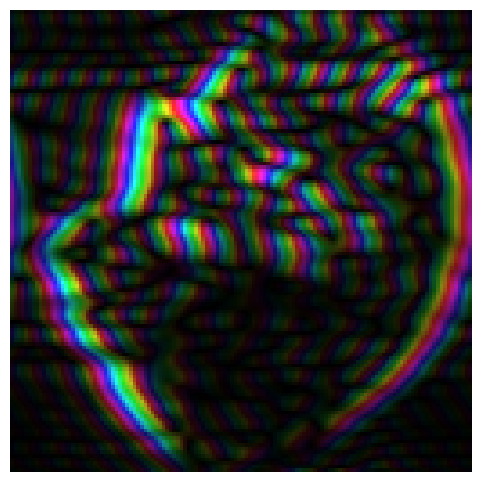

In [12]:
from torchvision.transforms import v2
from torchvision import transforms
import gc

gc.collect()

def shearlet_transform(img):
    img = torch.cat([
                     batched_spatial_coefficients(img[:, 0], shearlets, patch_size),
                     batched_spatial_coefficients(img[:, 1], shearlets, patch_size),
                     batched_spatial_coefficients(img[:, 2], shearlets, patch_size),
                     ], 1).type(torch.complex64)
    return img

def repeat3(x):
    return x.repeat(3, 1, 1)[:3]

transform = v2.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    repeat3,
])

ds_train = torchvision.datasets.Caltech101('./', transform=transform, download = True)
ds_train = IndexSubsetDataset(ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], []))

ds_val = torchvision.datasets.Caltech101('./', transform=transform, download = True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

train_loader = torch.utils.data.DataLoader(
  ds_train,
  batch_size=batch_size_train, shuffle=True, num_workers=0)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
  ds_val,
  batch_size=128, shuffle=False)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [batch_size_train, shearlets.shape[0] * 3, image_size, image_size], x.shape
    print(x[0][0].shape)
    visual.complexImageShow(x[0][0].cpu() / x[0][0].real.max().cpu())
    break



### Baseline - just a conv network

In [13]:
from torchvision.transforms import v2
from torchvision import transforms
import gc

gc.collect()

def repeat3(x):
    return x.repeat(3, 1, 1)[:3]

transform = v2.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    repeat3,
    transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                    ),
])

ds_train = torchvision.datasets.Caltech101('./', transform=transform, download = True)
ds_train = IndexSubsetDataset(ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], []))

ds_val = torchvision.datasets.Caltech101('./', transform=transform, download = True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

train_loader = torch.utils.data.DataLoader(
  ds_train,
  batch_size=batch_size_train, shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(
  ds_val,
  batch_size=128, shuffle=False)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [batch_size_train, 3, image_size, image_size], x.shape
    break
print('building model...')
model = torchvision.models.resnet18()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print('training model...')
for epoch in range(10):
    print('epoch', epoch)
    train(model.to(0), optimizer, train_loader, accumulate=4)
    gc.collect()
    test(model, train_loader)
    test(model, val_loader)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/109 [00:00<?, ?it/s]


building model...
training model...
epoch 0


109it [00:34,  3.13it/s]



Test set: Avg. loss: 0.0705, Accuracy: 1455/6941 (21%)


Test set: Avg. loss: 0.0370, Accuracy: 358/1736 (21%)

epoch 1


109it [00:17,  6.09it/s]



Test set: Avg. loss: 0.0553, Accuracy: 1869/6941 (27%)


Test set: Avg. loss: 0.0297, Accuracy: 446/1736 (26%)

epoch 2


109it [00:18,  6.02it/s]



Test set: Avg. loss: 0.0489, Accuracy: 2162/6941 (31%)


Test set: Avg. loss: 0.0268, Accuracy: 519/1736 (30%)

epoch 3


109it [00:16,  6.45it/s]



Test set: Avg. loss: 0.0444, Accuracy: 2644/6941 (38%)


Test set: Avg. loss: 0.0249, Accuracy: 589/1736 (34%)

epoch 4


109it [00:16,  6.42it/s]



Test set: Avg. loss: 0.0407, Accuracy: 2946/6941 (42%)


Test set: Avg. loss: 0.0235, Accuracy: 649/1736 (37%)

epoch 5


109it [00:16,  6.49it/s]



Test set: Avg. loss: 0.0368, Accuracy: 3317/6941 (48%)


Test set: Avg. loss: 0.0221, Accuracy: 711/1736 (41%)

epoch 6


108it [00:18,  5.75it/s]


KeyboardInterrupt: 

### First Experiment: Complex Conv on the coeffs in the spatial domain - just like coshnet

In [13]:
from torchvision.transforms import v2
from torchvision import transforms
import gc

gc.collect()

def shearlet_transform(img):
    img = torch.cat([
                     batched_frequency_coefficients(img[:, 0], shearlets, patch_size)[:, :1],
                     batched_frequency_coefficients(img[:, 1], shearlets, patch_size)[:, :1],
                     batched_frequency_coefficients(img[:, 2], shearlets, patch_size)[:, :1],
                     ], 1).type(torch.complex64)
    return img

def repeat3(x):
    return x.repeat(3, 1, 1)[:3]

transform = v2.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    repeat3,
])

ds_train = torchvision.datasets.Caltech101('./', transform=transform, download = True)
ds_train = IndexSubsetDataset(ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], []))

ds_val = torchvision.datasets.Caltech101('./', transform=transform, download = True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

train_loader = torch.utils.data.DataLoader(
  ds_train,
  batch_size=batch_size_train, shuffle=True, num_workers=0)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
  ds_val,
  batch_size=batch_size_train, shuffle=False)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [batch_size_train, 3, patch_size, patch_size], x.shape
    break

print('building model...')
model = complex_resnet18(in_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
print('training model...')
for epoch in range(10):
    print('epoch', epoch)
    train(model.to(0), optimizer, train_loader, accumulate=8)
    gc.collect()
    test(model, train_loader)
    test(model, val_loader)

Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]


building model...
training model...
epoch 0


217it [02:18,  1.56it/s]



Test set: Avg. loss: 0.1409, Accuracy: 638/6941 (9%)


Test set: Avg. loss: 0.1425, Accuracy: 160/1736 (9%)

epoch 1


217it [02:43,  1.32it/s]



Test set: Avg. loss: 0.1336, Accuracy: 640/6941 (9%)


Test set: Avg. loss: 0.1358, Accuracy: 160/1736 (9%)

epoch 2


217it [02:59,  1.21it/s]



Test set: Avg. loss: 0.1305, Accuracy: 638/6941 (9%)


Test set: Avg. loss: 0.1327, Accuracy: 160/1736 (9%)

epoch 3


217it [03:24,  1.06it/s]



Test set: Avg. loss: 0.1282, Accuracy: 638/6941 (9%)


Test set: Avg. loss: 0.1309, Accuracy: 160/1736 (9%)

epoch 4


217it [03:24,  1.06it/s]



Test set: Avg. loss: 0.1248, Accuracy: 852/6941 (12%)


Test set: Avg. loss: 0.1274, Accuracy: 213/1736 (12%)

epoch 5


217it [03:27,  1.04it/s]



Test set: Avg. loss: 0.1288, Accuracy: 1011/6941 (15%)


Test set: Avg. loss: 0.1309, Accuracy: 257/1736 (15%)

epoch 6


217it [03:33,  1.02it/s]



Test set: Avg. loss: 0.1240, Accuracy: 1254/6941 (18%)


Test set: Avg. loss: 0.1264, Accuracy: 298/1736 (17%)

epoch 7


217it [03:33,  1.02it/s]



Test set: Avg. loss: 0.1219, Accuracy: 1129/6941 (16%)


Test set: Avg. loss: 0.1244, Accuracy: 274/1736 (16%)

epoch 8


217it [03:38,  1.01s/it]



Test set: Avg. loss: 0.1203, Accuracy: 1175/6941 (17%)


Test set: Avg. loss: 0.1234, Accuracy: 296/1736 (17%)

epoch 9


217it [03:42,  1.03s/it]



Test set: Avg. loss: 0.1189, Accuracy: 1012/6941 (15%)


Test set: Avg. loss: 0.1221, Accuracy: 254/1736 (15%)



### Second Experiment: Complex Conv on the coeffs in the spatial domain using Luminance-Chrominance channels

In [ ]:
from torchvision.transforms import v2
from torchvision import transforms
import gc

gc.collect()

def shearlet_transform(img):
    img = torch.cat([
                     batched_spatial_coefficients(img[:, 0], shearlets, patch_size),
                     batched_spatial_coefficients(img[:, 1], shearlets, patch_size),
                     batched_spatial_coefficients(img[:, 2], shearlets, patch_size),
                     ], 1).type(torch.complex64)
    return img

def repeat3(x):
    return x.repeat(3, 1, 1)[:3]

transform = v2.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    repeat3,
    color.rgb_to_ycbcr
])

ds_train = torchvision.datasets.Caltech101('./', transform=transform, download = True)
ds_train = IndexSubsetDataset(ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], []))

ds_val = torchvision.datasets.Caltech101('./', transform=transform, download = True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

train_loader = torch.utils.data.DataLoader(
  ds_train,
  batch_size=batch_size_train, shuffle=True, num_workers=0)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
  ds_val,
  batch_size=batch_size_train, shuffle=False)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [batch_size_train, shearlets.shape[0] * 3, image_size, image_size], x.shape
    break
print('building model...')
model = complex_resnet34(in_dim=shearlets.shape[0] * 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print('training model...')
for epoch in range(10):
    print('epoch', epoch)
    train(model.to(0), optimizer, train_loader, accumulate=4)
    gc.collect()
    test(model, train_loader)
    test(model, val_loader)

Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]


building model...
training model...
epoch 0


109it [02:07,  1.17s/it]



Test set: Avg. loss: 0.0804, Accuracy: 640/6941 (9%)


Test set: Avg. loss: 0.0828, Accuracy: 160/1736 (9%)

epoch 1


109it [02:08,  1.18s/it]



Test set: Avg. loss: 0.0671, Accuracy: 640/6941 (9%)


Test set: Avg. loss: 0.0695, Accuracy: 160/1736 (9%)

epoch 2


109it [02:06,  1.16s/it]



Test set: Avg. loss: 0.0671, Accuracy: 638/6941 (9%)


Test set: Avg. loss: 0.0693, Accuracy: 160/1736 (9%)

epoch 3


109it [02:05,  1.15s/it]



Test set: Avg. loss: 0.0662, Accuracy: 640/6941 (9%)


Test set: Avg. loss: 0.0682, Accuracy: 160/1736 (9%)

epoch 4


109it [02:05,  1.15s/it]



Test set: Avg. loss: 0.0658, Accuracy: 638/6941 (9%)


Test set: Avg. loss: 0.0679, Accuracy: 160/1736 (9%)

epoch 5


109it [02:05,  1.15s/it]



Test set: Avg. loss: 0.0642, Accuracy: 640/6941 (9%)


Test set: Avg. loss: 0.0665, Accuracy: 160/1736 (9%)

epoch 6


109it [02:04,  1.14s/it]



Test set: Avg. loss: 0.0647, Accuracy: 640/6941 (9%)


Test set: Avg. loss: 0.0667, Accuracy: 160/1736 (9%)

epoch 7


109it [02:05,  1.15s/it]



Test set: Avg. loss: 0.0627, Accuracy: 984/6941 (14%)


Test set: Avg. loss: 0.0650, Accuracy: 251/1736 (14%)

epoch 8


109it [02:07,  1.17s/it]



Test set: Avg. loss: 0.0610, Accuracy: 1185/6941 (17%)


Test set: Avg. loss: 0.0632, Accuracy: 300/1736 (17%)

epoch 9


109it [02:10,  1.19s/it]



Test set: Avg. loss: 0.0607, Accuracy: 1021/6941 (15%)


Test set: Avg. loss: 0.0627, Accuracy: 253/1736 (15%)



### Third Experiment: Complex Conv on the coeffs in the frequency domain (increased spatial sparsity)

In [ ]:
from torchvision.transforms import v2
from torchvision import transforms
import gc

gc.collect()

def shearlet_transform(img):
    img = torch.cat([
                     batched_frequency_coefficients(img[:, 0], shearlets, patch_size),
                     batched_frequency_coefficients(img[:, 1], shearlets, patch_size),
                     batched_frequency_coefficients(img[:, 2], shearlets, patch_size),
                     ], 1).type(torch.complex64)
    return img

def repeat3(x):
    return x.repeat(3, 1, 1)[:3]

transform = v2.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    repeat3,
])

ds_train = torchvision.datasets.Caltech101('./', transform=transform, download = True)
ds_train = IndexSubsetDataset(ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], []))

ds_val = torchvision.datasets.Caltech101('./', transform=transform, download = True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

train_loader = torch.utils.data.DataLoader(
  ds_train,
  batch_size=batch_size_train, shuffle=True, num_workers=0)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
  ds_val,
  batch_size=batch_size_train, shuffle=False)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [batch_size_train, shearlets.shape[0] * 3, patch_size, patch_size], x.shape
    break
print('building model...')
model = complex_resnet34(in_dim=shearlets.shape[0] * 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print('training model...')
for epoch in range(10):
    print('epoch', epoch)
    train(model.to(0), optimizer, train_loader, accumulate=4)
    gc.collect()
    test(model, train_loader)
    test(model, val_loader)

Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]


building model...
training model...
epoch 0


109it [00:42,  2.55it/s]



Test set: Avg. loss: 0.0753, Accuracy: 693/6941 (10%)


Test set: Avg. loss: 0.0784, Accuracy: 187/1736 (11%)

epoch 1


109it [00:43,  2.50it/s]



Test set: Avg. loss: 0.0673, Accuracy: 895/6941 (13%)


Test set: Avg. loss: 0.0705, Accuracy: 223/1736 (13%)

epoch 2


109it [00:43,  2.50it/s]



Test set: Avg. loss: 0.0651, Accuracy: 1021/6941 (15%)


Test set: Avg. loss: 0.0683, Accuracy: 243/1736 (14%)

epoch 3


109it [00:43,  2.53it/s]



Test set: Avg. loss: 0.0638, Accuracy: 1117/6941 (16%)


Test set: Avg. loss: 0.0672, Accuracy: 247/1736 (14%)

epoch 4


109it [00:47,  2.31it/s]



Test set: Avg. loss: 0.0627, Accuracy: 1137/6941 (16%)


Test set: Avg. loss: 0.0666, Accuracy: 251/1736 (14%)

epoch 5


109it [00:45,  2.41it/s]



Test set: Avg. loss: 0.0609, Accuracy: 1328/6941 (19%)


Test set: Avg. loss: 0.0655, Accuracy: 302/1736 (17%)

epoch 6


109it [00:44,  2.46it/s]



Test set: Avg. loss: 0.0599, Accuracy: 1335/6941 (19%)


Test set: Avg. loss: 0.0649, Accuracy: 312/1736 (18%)

epoch 7


109it [00:46,  2.33it/s]



Test set: Avg. loss: 0.0588, Accuracy: 1357/6941 (20%)


Test set: Avg. loss: 0.0641, Accuracy: 294/1736 (17%)

epoch 8


109it [00:50,  2.14it/s]



Test set: Avg. loss: 0.0572, Accuracy: 1600/6941 (23%)


Test set: Avg. loss: 0.0639, Accuracy: 354/1736 (20%)

epoch 9


109it [00:49,  2.21it/s]



Test set: Avg. loss: 0.0558, Accuracy: 1611/6941 (23%)


Test set: Avg. loss: 0.0630, Accuracy: 353/1736 (20%)



### Second Experiment: Complex Conv on the coeffs in the frequency domain using Luminance-Chrominance channels (increased spatial sparsity)

In [ ]:
from torchvision.transforms import v2
from torchvision import transforms
import gc

gc.collect()

def shearlet_transform(img):
    img = torch.cat([
                     batched_frequency_coefficients(img[:, 0], shearlets, patch_size),
                     batched_frequency_coefficients(img[:, 1], shearlets, patch_size),
                     batched_frequency_coefficients(img[:, 2], shearlets, patch_size),
                     ], 1).type(torch.complex64)
    return img

def repeat3(x):
    return x.repeat(3, 1, 1)[:3]

transform = v2.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    repeat3,
    color.rgb_to_ycbcr,
])

ds_train = torchvision.datasets.Caltech101('./', transform=transform, download = True)
ds_train = IndexSubsetDataset(ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], []))

ds_val = torchvision.datasets.Caltech101('./', transform=transform, download = True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

train_loader = torch.utils.data.DataLoader(
  ds_train,
  batch_size=batch_size_train, shuffle=True, num_workers=0)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
  ds_val,
  batch_size=batch_size_train, shuffle=False)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [batch_size_train, shearlets.shape[0] * 3, patch_size, patch_size], x.shape
    break
print('building model...')
model = complex_resnet34(in_dim=shearlets.shape[0] * 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print('training model...')
for epoch in range(10):
    print('epoch', epoch)
    train(model.to(0), optimizer, train_loader, accumulate=4)
    gc.collect()
    test(model, train_loader)
    test(model, val_loader)

Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]


building model...
training model...
epoch 0


109it [00:50,  2.15it/s]



Test set: Avg. loss: 0.0753, Accuracy: 501/6941 (7%)


Test set: Avg. loss: 0.0774, Accuracy: 115/1736 (7%)

epoch 1


109it [00:57,  1.90it/s]



Test set: Avg. loss: 0.0685, Accuracy: 707/6941 (10%)


Test set: Avg. loss: 0.0704, Accuracy: 182/1736 (10%)

epoch 2


109it [00:47,  2.31it/s]



Test set: Avg. loss: 0.0662, Accuracy: 948/6941 (14%)


Test set: Avg. loss: 0.0687, Accuracy: 232/1736 (13%)

epoch 3


109it [00:46,  2.33it/s]



Test set: Avg. loss: 0.0635, Accuracy: 1122/6941 (16%)


Test set: Avg. loss: 0.0660, Accuracy: 271/1736 (16%)

epoch 4


109it [00:48,  2.24it/s]



Test set: Avg. loss: 0.0622, Accuracy: 1247/6941 (18%)


Test set: Avg. loss: 0.0658, Accuracy: 297/1736 (17%)

epoch 5


109it [00:47,  2.32it/s]



Test set: Avg. loss: 0.0588, Accuracy: 1504/6941 (22%)


Test set: Avg. loss: 0.0622, Accuracy: 347/1736 (20%)

epoch 6


109it [00:45,  2.40it/s]



Test set: Avg. loss: 0.0563, Accuracy: 1669/6941 (24%)


Test set: Avg. loss: 0.0602, Accuracy: 390/1736 (22%)

epoch 7


109it [00:47,  2.29it/s]



Test set: Avg. loss: 0.0544, Accuracy: 1738/6941 (25%)


Test set: Avg. loss: 0.0582, Accuracy: 397/1736 (23%)

epoch 8


109it [00:47,  2.32it/s]



Test set: Avg. loss: 0.0522, Accuracy: 1832/6941 (26%)


Test set: Avg. loss: 0.0568, Accuracy: 431/1736 (25%)

epoch 9


109it [00:48,  2.25it/s]



Test set: Avg. loss: 0.0509, Accuracy: 2086/6941 (30%)


Test set: Avg. loss: 0.0558, Accuracy: 475/1736 (27%)

